In [ ]:
# EEG to Text using BiLSTM + CNN with Preprocessed ZuCo Data

In [3]:
pip install torch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
## Step 1: Imports and Setup
import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

C:\Users\Vedashree\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import h5py

# Replace with your file path
file_path = './Normal/gip_ZAB_TSR1_EEG.mat'

with h5py.File(file_path, 'r') as f:
    # Step 1: Inspect the file structure
    print("Top-level keys:", list(f.keys()))

    # Step 2: Navigate to the EEG struct
    eeg_group = f['EEG']  # Replace 'EEG' with actual key if different

    eeg_group = f['EEG']  # Replace 'EEG' with your group name
    print("EEG group keys:", list(eeg_group.keys()))
    eeg_data = eeg_group['data'][()]
    print(eeg_data.shape)
    # # Step 3: Access the 'data' field inside the EEG struct
    # data_ref = eeg_group['data'][()]  # [()] extracts the dataset

    # # Step 4: Convert from HDF5 reference to NumPy array
    # ref_str = str(data_ref[0, 0])  # Convert to string
    # eeg_data = f['0.21072988'][()]      # Now works with string key
    # eeg_data = eeg_data.T  # Transpose to fix MATLAB/Python dimension order


Top-level keys: ['#refs#', 'EEG', 'auto_badchans', 'automagic', 'ica_rejected', 'is_interpolated', 'man_badchans', 'params', 'rate', 'tobe_interpolated']
EEG group keys: ['chaninfo', 'chanlocs', 'comments', 'condition', 'data', 'datfile', 'dipfit', 'epoch', 'epochdescription', 'etc', 'event', 'eventdescription', 'filename', 'filepath', 'group', 'history', 'icaact', 'icachansind', 'icasphere', 'icasplinefile', 'icaweights', 'icawinv', 'nbchan', 'pnts', 'ref', 'reject', 'saved', 'session', 'setname', 'specdata', 'specicaact', 'splinefile', 'srate', 'stats', 'subject', 'times', 'trials', 'urchanlocs', 'urevent', 'xmax', 'xmin']
(132033, 105)


In [63]:
print(eeg_data)

[[  0.21072988   0.49722767  -1.6659039  ...   1.0112903    1.4383821
    0.        ]
 [ -3.9211714   -4.380871    -0.9880711  ...  -5.2019167   -4.175181
    0.        ]
 [ -0.95888007  -0.4234106    1.7352796  ...  -1.3343148   -0.22025394
    0.        ]
 ...
 [ -4.2372437   -5.320451   -10.291676   ...  -5.0862556   -5.0496416
    0.        ]
 [ -3.5731385   -4.3585987  -10.103533   ...  -2.941593    -3.4416058
    0.        ]
 [ -7.4440055   -9.340462   -10.528616   ...  -7.1306543   -7.6002626
    0.        ]]


In [ ]:
with open('sentencesTSR.mat', 'rb') as f:
    print(f.read(8))

b'MATLAB 5'


In [3]:
from scipy.io import loadmat
sentdata = loadmat('./sentencesTSR.mat')
# sentdata

In [3]:
import scipy.io

data = scipy.io.loadmat('sentencesTSR.mat')
# Find the main key (not __header__, __version__, __globals__)
main_key = [k for k in data.keys() if not k.startswith('__')][0]
sentences_array = data[main_key]
all_sentences = [sentences_array[i, 0] for i in range(sentences_array.shape[0])]


In [4]:
all_sentences

[array(['He won the Gold Medal of the Royal Astronomical Society in 1892, and also later served as president of that organization.'],
       dtype='<U121'),
 array(['Dole was twice decorated for heroic achievement, receiving two Purple Hearts for his injuries, and the Bronze Star Medal for his attempt to assist a downed radio man.'],
       dtype='<U166'),
 array(['President Clinton awarded him the Presidential Medal of Freedom in early 1997 for his service in the military and his political career.'],
       dtype='<U135'),
 array(['The book was awarded the 1957 Pulitzer Prize for Biography.'],
       dtype='<U59'),
 array(['The Foundation has grown immensely and, by 1950, had become national and international in scope.'],
       dtype='<U96'),
 array(["Kennedy's other decorations of the Second World War include the Purple Heart, Asiatic-Pacific Campaign Medal, and the World War II Victory Medal."],
       dtype='<U145'),
 array(['Sir Andrew Fielding Huxley, OM, FRS (born 22 November 1

In [7]:
from scipy.io import loadmat
fixations_data = loadmat('./Eye_tracking/ZAB_TSR1_corrected_ET.mat')

In [8]:
fixations=fixations_data['eyeevent']['fixations']
fixations_str=fixations[0,0]
fix_eye=fixations_str['eye']
fix_data=fixations_str['data']

In [9]:
fix_data[0,0].shape
fix_eye[0,0].shape
numeric_fixation_data=fix_data[0,0]

In [10]:
start_times = numeric_fixation_data[:, 0]
end_times = numeric_fixation_data[:, 1]
word_indices = numeric_fixation_data[:, 3].astype(int)

In [11]:
start_times

array([2205831., 2205979., 2206079., ..., 2464685., 2464875., 2465103.])

In [12]:
srate = 500  # EEG sampling rate in Hz

start_samples = (start_times * srate / 1000).astype(int)
end_samples = (end_times * srate / 1000).astype(int)


In [13]:
# Assuming start_times are in microseconds:
start_samples = (start_times / 1_000_000 * 500).astype(int)  # 500 Hz
end_samples = (end_times / 1_000_000 * 500).astype(int)

# Extract segments with bounds checking
word_segments = []
for start, end in zip(start_samples, end_samples):
    if start < 0 or end > eeg_data.shape[0] or start >= end:
        continue  # Skip invalid
    word_segments.append(eeg_data[start:end, :])

print(f"Extracted {len(word_segments)} valid EEG segments")


Extracted 97 valid EEG segments


In [45]:
print(type(all_sentences[0]))
print(all_sentences[0])


<class 'numpy.ndarray'>
['He won the Gold Medal of the Royal Astronomical Society in 1892, and also later served as president of that organization.']


In [5]:
# If each sentence is an array of words:
if isinstance(all_sentences[0], (np.ndarray, list)):
    all_sentences = [' '.join(sentence) for sentence in all_sentences]


In [9]:
len(all_sentences)

407

In [16]:
all_words = [word for sentence in all_sentences for word in sentence.split()]

words = []
for idx in word_indices:
    if 0 < idx <= len(all_words):  # 1-based indexing
        words.append(all_words[idx - 1])
    else:
        words.append('<UNK>')


In [17]:
# pad eeg segments to fixed length
import numpy as np

def pad_sequences(sequences, maxlen, dtype='float32', padding='post', truncating='post'):
    num_samples = len(sequences)
    if num_samples == 0:
        return np.array([])
    num_features = sequences[0].shape[1]
    padded = np.zeros((num_samples, maxlen, num_features), dtype=dtype)
    for i, seq in enumerate(sequences):
        length = min(len(seq), maxlen)
        if truncating == 'post':
            trunc = seq[:length]
        else:
            trunc = seq[-length:]
        if padding == 'post':
            padded[i, :length, :] = trunc
        else:
            padded[i, -length:, :] = trunc
    return padded

max_length = 250  # e.g., 500 ms at 500 Hz
padded_segments = pad_sequences(word_segments, maxlen=max_length, padding='post', truncating='post')


In [18]:
print("EEG data shape:", eeg_data.shape)


EEG data shape: (132033, 105)


In [19]:
print("First 5 start samples:", start_samples[:5])
print("First 5 end samples:", end_samples[:5])


First 5 start samples: [1102 1102 1103 1103 1103]
First 5 end samples: [1102 1103 1103 1103 1103]


In [21]:
# 1. Load fixation data
start_times = fix_data[0,0][:, 0]  # Column 0: start_time (µs)
end_times = fix_data[0,0][:, 1]    # Column 1: end_time (µs)

# 2. Convert to samples
srate = 500
start_samples = (start_times / 1_000_000 * srate).astype(int)
end_samples = (end_times / 1_000_000 * srate).astype(int)

# 3. Ensure end > start
end_samples = np.maximum(end_samples, start_samples + 1)

# 4. Extract valid segments
word_segments = []
for start, end in zip(start_samples, end_samples):
    if 0 <= start < eeg_data.shape[0] and 0 < end <= eeg_data.shape[0]:
        word_segments.append(eeg_data[start:end, :])
    else:
        print(f"Invalid: {start}-{end}")

# 5. Pad segments
max_length = 250  # 500 ms
padded_segments = np.zeros((len(word_segments), max_length, 105), dtype=np.float32)
for i, seg in enumerate(word_segments):
    length = min(len(seg), max_length)
    padded_segments[i, :length, :] = seg[:length, :]


In [22]:
# Flatten all_sentences into a list of words
all_words = [word for sentence in all_sentences for word in sentence.split()]

# Map word indices from fixation data to actual words
# (Assume word_indices is already extracted and 1-based)
words = []
for idx in word_indices:
    if 0 < idx <= len(all_words):
        words.append(all_words[idx - 1])
    else:
        words.append('<UNK>')  # For out-of-bounds indices


In [23]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
encoded_labels = le.fit_transform(words[:len(padded_segments)])  # Align lengths


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    padded_segments, encoded_labels, test_size=0.2, random_state=42
)


In [25]:
from tensorflow.keras import layers, models

vocab_size = len(le.classes_)
max_length = padded_segments.shape[1]
num_channels = padded_segments.shape[2]

model = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=(max_length, num_channels)),
    layers.MaxPooling1D(2),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(vocab_size, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))


C:\Users\Vedashree\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 254ms/step - accuracy: 0.0540 - loss: 5.4463 - val_accuracy: 0.1067 - val_loss: 5.0754
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.0728 - loss: 5.0027 - val_accuracy: 0.1067 - val_loss: 5.1341
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.0668 - loss: 4.9874 - val_accuracy: 0.1067 - val_loss: 5.1688
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.0645 - loss: 4.8665 - val_accuracy: 0.1067 - val_loss: 5.1990
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.0944 - loss: 4.7893 - val_accuracy: 0.0978 - val_loss: 5.2597
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.0813 - loss: 4.7444 - val_accuracy: 0.0978 - val_loss: 5.2885
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - accuracy: 0.0743 - loss: 4.7542 - val_accuracy: 0.1022 - val_loss: 5.3407
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.0897 - loss: 4.6374 - val_accuracy: 0

In [26]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy*100:.2f}%")
print(f"Vocabulary size: {vocab_size}")
print(f"Chance level: {100/vocab_size:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0439 - loss: 6.0376
Test accuracy: 5.33%
Vocabulary size: 249
Chance level: 0.40%


In [166]:
# Convert each sentence to a string if it's a list or numpy array of words
if isinstance(all_sentences[0], (np.ndarray, list)):
    all_sentences = [' '.join(sentence) for sentence in all_sentences]
    
all_sentences


['He won the Gold Medal of the Royal Astronomical Society in 1892, and also later served as president of that organization.',
 'Dole was twice decorated for heroic achievement, receiving two Purple Hearts for his injuries, and the Bronze Star Medal for his attempt to assist a downed radio man.',
 'President Clinton awarded him the Presidential Medal of Freedom in early 1997 for his service in the military and his political career.',
 'The book was awarded the 1957 Pulitzer Prize for Biography.',
 'The Foundation has grown immensely and, by 1950, had become national and international in scope.',
 "Kennedy's other decorations of the Second World War include the Purple Heart, Asiatic-Pacific Campaign Medal, and the World War II Victory Medal.",
 'Sir Andrew Fielding Huxley, OM, FRS (born 22 November 1917, Hampstead, London, England, UK) is a British physiologist and biophysicist, who won the 1963 Nobel Prize in Physiology or Medicine for his work with Alan Lloyd Hodgkin on the basis of ne

In [54]:
print(type(all_sentences))
print(all_sentences[:2])  # Show first two elements for confirmation


<class 'list'>
['He won the Gold Medal of the Royal Astronomical Society in 1892, and also later served as president of that organization.', 'Dole was twice decorated for heroic achievement, receiving two Purple Hearts for his injuries, and the Bronze Star Medal for his attempt to assist a downed radio man.']


In [10]:
import os
import re
import numpy as np
import h5py
from scipy.io import loadmat

def extract_session_id(filename):
    match = re.search(r'(TSR\d+)', filename.upper())
    return match.group() if match else None

def pad_sequences_manual(sequences, maxlen=250, num_channels=105):
    padded = np.zeros((len(sequences), maxlen, num_channels), dtype=np.float32)
    for i, seq in enumerate(sequences):
        length = min(len(seq), maxlen)
        padded[i, :length, :] = seq[:length, :]
    return padded

def combine_sessions(eeg_dir, et_dir, all_sentences, srate=500, max_length=250):
    eeg_segments = []
    word_labels = []
    # Ensure all_sentences is a list of strings
    if isinstance(all_sentences[0], (np.ndarray, list)):
        all_sentences = [' '.join(sentence) for sentence in all_sentences]
    all_words = [word for sentence in all_sentences for word in sentence.split()]
    eeg_files = [f for f in os.listdir(eeg_dir) if f.endswith('.mat')]
    et_files = [f for f in os.listdir(et_dir) if f.endswith('.mat')]

    for eeg_file in eeg_files:
       
        session_id = extract_session_id(eeg_file)
        if not session_id:
            continue
        et_file = next((f for f in et_files if session_id in f.upper()), None)
        if not et_file:
            print(f"No ET file for EEG file {eeg_file}")
            continue

        eeg_path = os.path.join(eeg_dir, eeg_file)
        et_path = os.path.join(et_dir, et_file)

        # --- Load EEG (h5py) ---
        try:
            with h5py.File(eeg_path, 'r') as f:
                # Explore keys if needed: print(list(f['EEG'].keys()))
                eeg_data = np.array(f['EEG']['data'])  # shape: (samples, channels)
                print(f"{eeg_file}: eeg_data.shape = {eeg_data.shape}")

        except Exception as e:
            print(f"Error loading EEG: {eeg_file}: {e}")
            continue

        # --- Load ET (scipy.io.loadmat) ---
        try:
            et_data = loadmat(et_path)
            fix_data = et_data['eyeevent']['fixations'][0,0]['data'][0,0]
            start_times = fix_data[:, 0]  # microseconds
            end_times = fix_data[:, 1]
            word_indices = fix_data[:, 3].astype(int)
        except Exception as e:
            print(f"Error loading ET: {et_file}: {e}")
            continue
        
        print("First 10 start_times (raw):", start_times[:10])
        print("First 10 end_times (raw):", end_times[:10])
        
        # Convert times to samples
        start_samples = (start_times / 1_000_000 * srate).astype(int)
        end_samples = (end_times / 1_000_000 * srate).astype(int)
        end_samples = np.maximum(end_samples, start_samples + 1)
        


        for start, end, idx in zip(start_samples, end_samples, word_indices):
            if 0 <= start < eeg_data.shape[0] and start < end <= eeg_data.shape[0]:
                segment = eeg_data[start:end, :]
                eeg_segments.append(segment)
                if 0 < idx <= len(all_words):
                    word_labels.append(all_words[idx - 1])
                else:
                    word_labels.append('<UNK>')
            else:
                print(f"Invalid segment: start={start}, end={end}, eeg_len={eeg_data.shape[0]}")

    if not eeg_segments:
        raise ValueError("No valid EEG segments found. Check your file matching and segment extraction logic.")

    num_channels = eeg_segments[0].shape[1]
    X = pad_sequences_manual(eeg_segments, max_length, num_channels)
    return X, word_labels

# Usage example:
eeg_dir = './Normal/'
et_dir = './Eye_tracking/'

X, words = combine_sessions(eeg_dir, et_dir, all_sentences)
print("X shape:", X.shape)
print("Number of labels:", len(words))


gip_ZAB_TSR1_EEG.mat: eeg_data.shape = (132033, 105)
First 10 start_times (raw): [2205831. 2205979. 2206079. 2206217. 2206359. 2206643. 2206827. 2206937.
 2207123. 2207315.]
First 10 end_times (raw): [2205933. 2206047. 2206197. 2206335. 2206621. 2206805. 2206913. 2207099.
 2207291. 2207565.]
gip_ZAB_TSR3_EEG.mat: eeg_data.shape = (79903, 105)
First 10 start_times (raw): [2889904. 2890030. 2890124. 2890288. 2890478. 2890638. 2890772. 2890952.
 2891066. 2891290.]
First 10 end_times (raw): [2889974. 2890082. 2890266. 2890452. 2890614. 2890750. 2890932. 2891020.
 2891264. 2891446.]
gip_ZAB_TSR4_EEG.mat: eeg_data.shape = (76779, 105)
First 10 start_times (raw): [3114259. 3114341. 3114449. 3114621. 3114771. 3114891. 3115105. 3115237.
 3115441. 3115557.]
First 10 end_times (raw): [3114295. 3114411. 3114599. 3114745. 3114845. 3115081. 3115213. 3115367.
 3115531. 3115765.]
gip_ZAB_TSR5_EEG.mat: eeg_data.shape = (68679, 105)
First 10 start_times (raw): [3330849. 3330945. 3331071. 3331249. 333141

In [11]:
from sklearn.preprocessing import LabelEncoder

# Convert word labels to integers
le = LabelEncoder()
y = le.fit_transform(words)
vocab_size = len(le.classes_)  # Number of unique words

print("Encoded labels shape:", y.shape)
print("Vocabulary size:", vocab_size)


Encoded labels shape: (6201,)
Vocabulary size: 313


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)


Train shapes: (4960, 250, 105) (4960,)
Test shapes: (1241, 250, 105) (1241,)


In [242]:
from tensorflow.keras import layers, models

def build_bilstm_cnn(input_shape, vocab_size):
    inputs = layers.Input(shape=input_shape)
    
    # CNN
    x = layers.Conv1D(64, 3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)
    
    # BiLSTM
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    
    # Classifier
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(vocab_size, activation='softmax')(x)
    
    return models.Model(inputs, outputs)

# Initialize
input_shape = (250, 105)
bilstm_cnn_model = build_bilstm_cnn(input_shape, vocab_size)
bilstm_cnn_model.summary()


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)          │ (None, 250, 105)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_38 (Conv1D)                   │ (None, 250, 64)             │          20,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_38 (MaxPooling1D)      │ (None, 125, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_39 (Conv1D)                   │ (None, 125, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_39 (MaxPooling1D)      │ (None, 62, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 62, 256)             │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 313)                 │          40,377 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 529,337 (2.02 MB)

 Trainable params: 529,337 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

In [146]:
from tensorflow.keras import layers, models

def transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    # Multi-Head Self Attention
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.Add()([x, inputs])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    # Feed Forward
    x_ff = layers.Dense(ff_dim, activation="relu")(x)
    x_ff = layers.Dense(inputs.shape[-1])(x_ff)
    x = layers.Add()([x, x_ff])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x

def build_eeg_transformer(input_shape, vocab_size):
    inputs = layers.Input(shape=input_shape)
    # CNN front-end
    x = layers.Conv1D(64, 3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)
    # Transformer encoder block
    x = transformer_encoder(x, head_size=32, num_heads=4, ff_dim=128, dropout=0.1)
    # Pooling and classifier
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(vocab_size, activation='softmax')(x)
    return models.Model(inputs, outputs)

# Usage:
input_shape = (250, 105)
model = build_eeg_transformer(input_shape, vocab_size)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)   │ (None, 250, 105)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_34 (Conv1D)            │ (None, 250, 64)           │          20,224 │ input_layer_17[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_34              │ (None, 125, 64)           │               0 │ conv1d_34[0][0]            │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_35 (Conv1D)            │ (None, 125, 128)          │          24,704 │ max_pooling1d_34[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_35              │ (None, 62, 128)           │               0 │ conv1d_35[0][0]            │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_19       │ (None, 62, 128)           │          66,048 │ max_pooling1d_35[0][0],    │
│ (MultiHeadAttention)          │                           │                 │ max_pooling1d_35[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_44 (Dropout)          │ (None, 62, 128)           │               0 │ multi_head_attention_19[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_38 (Add)                  │ (None, 62, 128)           │               0 │ dropout_44[0][0],          │
│                               │                           │                 │ max_pooling1d_35[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_38        │ (None, 62, 128)           │             256 │ add_38[0][0]               │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_70 (Dense)              │ (None, 62, 128)           │          16,512 │ layer_normalization_38[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_71 (Dense)              │ (None, 62, 128)           │          16,512 │ dense_70[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_39 (Add)                  │ (None, 62, 128)           │               0 │ layer_normalization_38[0]… │
│                               │                           │                 │ dense_71[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_39        │ (None, 62, 128)           │             256 │ add_39[0][0]               │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d_14   │ (None, 128)               │               

 Total params: 201,401 (786.72 KB)

 Trainable params: 201,401 (786.72 KB)

 Non-trainable params: 0 (0.00 B)

In [243]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=30):
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=32,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
        ]
    )
    return history

# Train BiLSTM-CNN
print("Training BiLSTM-CNN...")
bilstm_history = train_model(bilstm_cnn_model, X_train, y_train, X_test, y_test)



Training BiLSTM-CNN...
Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 66s 227ms/step - accuracy: 0.0694 - loss: 5.4042 - val_accuracy: 0.0757 - val_loss: 5.2027
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 33s 213ms/step - accuracy: 0.0719 - loss: 5.1359 - val_accuracy: 0.0757 - val_loss: 5.1923
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 33s 211ms/step - accuracy: 0.0719 - loss: 5.1371 - val_accuracy: 0.0757 - val_loss: 5.1862
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 35s 225ms/step - accuracy: 0.0690 - loss: 5.1335 - val_accuracy: 0.0757 - val_loss: 5.2173
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 36s 231ms/step - accuracy: 0.0705 - loss: 5.0978 - val_accuracy: 0.0757 - val_loss: 5.1861
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 35s 222ms/step - accuracy: 0.0727 - loss: 5.1358 - val_accuracy: 0.0757 - val_loss: 5.2094
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 40s 217ms/step - accuracy: 0.0661 - loss: 5.1264 - val_accuracy: 0.0757 - val_loss: 5.2048
Epoch 8/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 34s 219ms/step - acc

In [256]:
import tensorflow as tf
from tensorflow.keras import layers, models

def transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    # Multi-Head Self Attention
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.Add()([x, inputs])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    # Feed Forward
    x_ff = layers.Dense(ff_dim, activation="relu")(x)
    x_ff = layers.Dense(inputs.shape[-1])(x_ff)
    x = layers.Add()([x, x_ff])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x

def build_eeg_transformer(input_shape, vocab_size):
    inputs = layers.Input(shape=input_shape)
    # CNN front-end
    x = layers.Conv1D(64, 3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)
    # Transformer encoder block
    x = transformer_encoder(x, head_size=32, num_heads=4, ff_dim=128, dropout=0.1)
    # Pooling and classifier
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(vocab_size, activation='softmax')(x)
    return models.Model(inputs, outputs)

# Define your input shape and vocab size
input_shape = (250, 105)  # (timesteps, channels)
vocab_size = len(set(y))  # Number of unique word labels

# Build and compile the model
model_trans = build_eeg_transformer(input_shape, vocab_size)
model_trans.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_trans.summary()

# Train the model
history = model_trans.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

# Evaluate
loss, acc = model_trans.evaluate(X_test, y_test)
print(f"Test accuracy: {acc:.3f}")


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)   │ (None, 250, 105)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_40 (Conv1D)            │ (None, 250, 64)           │          20,224 │ input_layer_20[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_40              │ (None, 125, 64)           │               0 │ conv1d_40[0][0]            │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_41 (Conv1D)            │ (None, 125, 128)          │          24,704 │ max_pooling1d_40[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_41              │ (None, 62, 128)           │               0 │ conv1d_41[0][0]            │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_21       │ (None, 62, 128)           │          66,048 │ max_pooling1d_41[0][0],    │
│ (MultiHeadAttention)          │                           │                 │ max_pooling1d_41[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_48 (Dropout)          │ (None, 62, 128)           │               0 │ multi_head_attention_21[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_42 (Add)                  │ (None, 62, 128)           │               0 │ dropout_48[0][0],          │
│                               │                           │                 │ max_pooling1d_41[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_42        │ (None, 62, 128)           │             256 │ add_42[0][0]               │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_80 (Dense)              │ (None, 62, 128)           │          16,512 │ layer_normalization_42[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_81 (Dense)              │ (None, 62, 128)           │          16,512 │ dense_80[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_43 (Add)                  │ (None, 62, 128)           │               0 │ layer_normalization_42[0]… │
│                               │                           │                 │ dense_81[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_43        │ (None, 62, 128)           │             256 │ add_43[0][0]               │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d_16   │ (None, 128)               │               

 Total params: 201,401 (786.72 KB)

 Trainable params: 201,401 (786.72 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 91s 180ms/step - accuracy: 0.0585 - loss: 5.4061 - val_accuracy: 0.0757 - val_loss: 5.1884
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.0688 - loss: 5.1444 - val_accuracy: 0.0757 - val_loss: 5.1864
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.0732 - loss: 5.1284 - val_accuracy: 0.0757 - val_loss: 5.1885
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 17s 110ms/step - accuracy: 0.0634 - loss: 5.1301 - val_accuracy: 0.0741 - val_loss: 5.1913
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.0690 - loss: 5.1133 - val_accuracy: 0.0757 - val_loss: 5.2106
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.0759 - loss: 5.1091 - val_accuracy: 0.0757 - val_loss: 5.2051
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.0736 - loss: 5.0723 - val_accuracy: 0.0757 - val_loss: 5.2037
Epoch 8/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.0667 - loss: 5

In [122]:
# from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

# # Suppose you have lists of sentences (as tokens):
# # true_sentences and pred_sentences are lists of strings

# # Tokenize sentences (split into words):
# references = [[ref.split()] for ref in true_sentences]  # List of list of references
# candidates = [pred.split() for pred in pred_sentences]  # List of candidate sentences

# # Calculate BLEU-4 (default)
# bleu_score = corpus_bleu(references, candidates)
# print(f"Corpus BLEU-4 score: {bleu_score:.4f}")

# # For BLEU-1 (unigram only):
# bleu1 = corpus_bleu(references, candidates, weights=(1, 0, 0, 0))
# print(f"Corpus BLEU-1 score: {bleu1:.4f}")


Corpus BLEU-4 score: 0.0000
Corpus BLEU-1 score: 0.0365


C:\Users\Vedashree\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Vedashree\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [244]:
def top_p_sampling(probs, p=0.9):
    preds = []
    for p_vec in probs:
        sorted_idx = np.argsort(p_vec)[::-1]  # Sort descending
        sorted_probs = p_vec[sorted_idx]
        cumulative_probs = np.cumsum(sorted_probs)
        cutoff = np.where(cumulative_probs > p)[0][0] + 1  # First index where sum > p
        candidates = sorted_idx[:cutoff]
        candidate_probs = sorted_probs[:cutoff]
        candidate_probs /= candidate_probs.sum()  # Normalize
        sampled = np.random.choice(candidates, p=candidate_probs)
        preds.append(sampled)
    return np.array(preds)

# Usage:
y_pred_indices = top_p_sampling(y_pred, p=0.9)


In [252]:
# !pip install rouge_score
import nltk
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
import numpy as np

# Download NLTK data if not already present
nltk.download('punkt', quiet=True)

# Tokenize sentences for BLEU
references = [[nltk.word_tokenize(ref)] for ref in true_sentences]
candidates = [nltk.word_tokenize(pred) for pred in pred_sentences]

# BLEU scores
bleu1 = corpus_bleu(references, candidates, weights=(1, 0, 0, 0))
bleu2 = corpus_bleu(references, candidates, weights=(0.5, 0.5, 0, 0))
bleu3 = corpus_bleu(references, candidates, weights=(0.33, 0.33, 0.33, 0))
bleu4 = corpus_bleu(references, candidates, weights=(0.25, 0.25, 0.25, 0.25))

print(f"BLEU-1: {bleu1:.4f}")
print(f"BLEU-2: {bleu2:.4f}")
print(f"BLEU-3: {bleu3:.4f}")
print(f"BLEU-4: {bleu4:.4f}")

# ROUGE scores
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge1_f1, rouge2_f1, rougeL_f1 = [], [], []

for ref, pred in zip(true_sentences, pred_sentences):
    scores = scorer.score(ref, pred)
    rouge1_f1.append(scores['rouge1'].fmeasure)
    rouge2_f1.append(scores['rouge2'].fmeasure)
    rougeL_f1.append(scores['rougeL'].fmeasure)

print(f"ROUGE-1 F1: {np.mean(rouge1_f1):.4f}")
print(f"ROUGE-2 F1: {np.mean(rouge2_f1):.4f}")
print(f"ROUGE-L F1: {np.mean(rougeL_f1):.4f}")


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24936 sha256=8038b3c5a1c2e845b3c1d941aefa3b76117d042e9d2d376b45112255ba62b93c
  Stored in directory: c:\users\vedashree\appdata\local\pip\cache\wheels\9b\3d\39\09558097d3119ca0a4d462df68f22c6f3c1b345ac63a09b86e
Successfully built rouge_score
BLEU-1: 0.4102
BLEU-2: 0.1709
BLEU-3: 0.0604
BLEU-4: 0.0182
ROUGE-1 F1: 0.0092
ROUGE-2 F1: 0.0007
ROUGE-L F1: 0.0035


In [149]:
print("X shape:", X.shape)
print("words length:", len(words))


X shape: (6201, 250, 105)
words length: 6201


In [74]:
pip install transformers


     ---------------------------------------- 10.4/10.4 MB 2.7 MB/s eta 0:00:00
     -------------------------------------- 484.2/484.2 kB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 2.4/2.4 MB 3.2 MB/s eta 0:00:00
     -------------------------------------- 308.9/308.9 kB 1.6 MB/s eta 0:00:00
     -------------------------------------- 194.4/194.4 kB 1.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2022.7.1
    Uninstalling fsspec-2022.7.1:
      Successfully uninstalled fsspec-2022.7.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0 requires mkl<=2021.4.0,>=2021.1.1, which is not installed.


In [167]:
all_sentences

['He won the Gold Medal of the Royal Astronomical Society in 1892, and also later served as president of that organization.',
 'Dole was twice decorated for heroic achievement, receiving two Purple Hearts for his injuries, and the Bronze Star Medal for his attempt to assist a downed radio man.',
 'President Clinton awarded him the Presidential Medal of Freedom in early 1997 for his service in the military and his political career.',
 'The book was awarded the 1957 Pulitzer Prize for Biography.',
 'The Foundation has grown immensely and, by 1950, had become national and international in scope.',
 "Kennedy's other decorations of the Second World War include the Purple Heart, Asiatic-Pacific Campaign Medal, and the World War II Victory Medal.",
 'Sir Andrew Fielding Huxley, OM, FRS (born 22 November 1917, Hampstead, London, England, UK) is a British physiologist and biophysicist, who won the 1963 Nobel Prize in Physiology or Medicine for his work with Alan Lloyd Hodgkin on the basis of ne

In [224]:
# X

In [241]:
import torch
import torch.nn as nn

class EEGTransformer(nn.Module):
    def __init__(self, input_dim=105, seq_len=250, d_model=128, num_heads=8, vocab_size=249):
        super().__init__()
        
        # Ensure d_model is divisible by num_heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # CNN Front-End
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        # Positional Encoding
        self.pos_encoder = nn.Parameter(torch.randn(1, 62, d_model))
        
        # Transformer Encoder
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=num_heads,
                dim_feedforward=256,
                dropout=0.1,
                batch_first=True
            ),
            num_layers=2
        )
        
        # Classifier
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        # Input shape: (batch, channels, seq_len)
        x = self.cnn(x)  # Output: (batch, 128, 62)
        
        # Reshape and add positional encoding
        x = x.permute(0, 2, 1)  # (batch, 62, 128)
        x += self.pos_encoder
        
        # Transformer processing
        x = self.transformer(x)
        
        # Global average pooling and classify
        x = x.mean(dim=1)  # (batch, d_model)
        x = self.fc(x)  # (batch, vocab_size)
        return x


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


TypeError: conv1d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mnumpy.ndarray[0m, [31;1mParameter[0m, [31;1mParameter[0m, [31;1mtuple of (int,)[0m, [31;1mtuple of (int,)[0m, [31;1mtuple of (int,)[0m, [32;1mint[0m)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mnumpy.ndarray[0m, [31;1mParameter[0m, [31;1mParameter[0m, [31;1mtuple of (int,)[0m, [31;1mtuple of (int,)[0m, [31;1mtuple of (int,)[0m, [32;1mint[0m)


In [232]:
X

tensor([[[-0.7021,  1.2427,  0.0267,  ...,  0.1473,  0.1641,  0.3230],
         [ 0.1075, -0.0745,  1.0862,  ..., -0.1978,  0.0475, -0.6439],
         [ 1.8104,  0.1410, -0.7643,  ..., -1.0770,  0.8530,  1.3855],
         ...,
         [-0.2895,  1.9293,  1.5469,  ...,  0.8384, -1.3347,  0.0267],
         [ 1.1881,  0.5530,  0.8335,  ..., -0.1350,  0.5716, -1.6299],
         [ 0.9313, -0.0856,  2.2476,  ..., -0.3617, -0.3344, -1.0917]],

        [[-0.7982,  0.8631, -0.7733,  ...,  0.1848,  1.3136, -0.2772],
         [-0.6772,  0.1812, -0.9508,  ...,  1.0330, -1.2770, -1.2611],
         [-0.2147, -0.8408,  0.1502,  ..., -0.8759, -0.7348, -0.7626],
         ...,
         [ 0.2125,  0.4428, -1.7165,  ..., -0.7477, -0.2743,  0.2123],
         [-1.3438, -0.5210, -0.0797,  ..., -0.1816, -0.6517, -0.2985],
         [ 0.9436,  1.2673, -0.2589,  ..., -0.4449,  1.4804,  0.7771]],

        [[ 1.2000, -0.3879, -0.8724,  ...,  0.9115, -0.7734, -0.0854],
         [-1.4619,  1.5035, -0.6558,  ...,  0

In [207]:
outputs

Seq2SeqLMOutput(loss=tensor(5.7306, grad_fn=<NllLossBackward0>), logits=tensor([[[ 3.4840e+01,  7.5608e+00,  1.4434e+01,  ...,  7.0986e+00,
           6.9660e+00,  1.7045e+00],
         [ 7.2185e+00, -2.3562e+00,  6.3971e+00,  ..., -1.6168e+00,
          -1.9104e+00,  1.5132e-01],
         [-8.9885e+00, -6.5871e+00, -3.4068e+00,  ..., -7.1882e+00,
          -7.5272e+00, -3.3917e+00],
         ...,
         [ 1.6796e-01, -5.6502e+00, -8.4985e-01,  ..., -6.0966e+00,
          -6.1362e+00, -4.4089e+00],
         [ 2.6040e-01, -5.7163e+00, -7.2492e-01,  ..., -6.1810e+00,
          -6.1700e+00, -2.2371e+00],
         [-5.1703e+00, -4.6832e+00, -5.6616e-01,  ..., -5.1432e+00,
          -5.6169e+00, -2.8392e+00]],

        [[ 3.4838e+01,  7.5596e+00,  1.4429e+01,  ...,  7.1028e+00,
           6.9914e+00,  1.7159e+00],
         [ 7.2692e+00, -2.4099e+00,  6.3476e+00,  ..., -1.7036e+00,
          -1.9361e+00,  1.6637e-01],
         [-9.0481e+00, -6.6776e+00, -3.7146e+00,  ..., -7.3439e+00,
    

In [175]:
# Load pretrained BART and tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

# Instantiate EEG encoder and full model
eeg_encoder = EEGEncoder(input_channels=105, seq_len=250, embed_dim=768)
model = EEG2TextModel(eeg_encoder, bart_model)

# Example EEG batch and text batch
# X: (batch, 250, 105) -> PyTorch expects (batch, channels, seq_len)
eeg_batch = torch.tensor(X[:8], dtype=torch.float32).permute(0, 2, 1)  # (8, 105, 250)
text_batch = all_sentences[:8]  # List of 8 reference sentences

inputs = tokenizer(text_batch, return_tensors='pt', padding=True, truncation=True)
outputs = model(eeg_batch, inputs['input_ids'], inputs['attention_mask'])
loss = outputs.loss


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [176]:
loss

In [257]:
def top_p_sampling(probs, p=0.9):
    preds = []
    for p_vec in probs:
        sorted_idx = np.argsort(p_vec)[::-1]  # Sort descending
        sorted_probs = p_vec[sorted_idx]
        cumulative_probs = np.cumsum(sorted_probs)
        cutoff = np.where(cumulative_probs > p)[0][0] + 1  # First index where sum > p
        candidates = sorted_idx[:cutoff]
        candidate_probs = sorted_probs[:cutoff]
        candidate_probs /= candidate_probs.sum()  # Normalize
        sampled = np.random.choice(candidates, p=candidate_probs)
        preds.append(sampled)
    return np.array(preds)

# Usage:
y_pred_indices = top_p_sampling(y_pred, p=0.9)


In [150]:
# import numpy as np

# def top_k_sampling(probs, k=5):
#     # probs: (num_samples, vocab_size)
#     preds = []
#     for p in probs:
#         top_k_idx = np.argpartition(p, -k)[-k:]
#         top_k_probs = p[top_k_idx]
#         top_k_probs = top_k_probs / np.sum(top_k_probs)
#         sampled = np.random.choice(top_k_idx, p=top_k_probs)
#         preds.append(sampled)
#     return np.array(preds)

# # Usage:
# y_pred = model_trans.predict(X_test)
# y_pred_indices = top_k_sampling(y_pred, k=5)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [258]:
# Convert indices to words
true_words = le.inverse_transform(y_test)
pred_words = le.inverse_transform(y_pred_indices)


In [259]:
import pandas as pd

# Show first N predictions as a table
N = 20
df = pd.DataFrame({
    "True Word": true_words[:N],
    "Predicted Word": pred_words[:N]
})
print(df)


      True Word Predicted Word
0         Medal        Marines
1            of            for
2         Human       England,
3     president        African
4            of             an
5           for          year,
6        Copley            and
7         Prize   potentials,"
8         Medal             an
9     activist.           role
10           be             of
11         Best          which
12       Medal.         Andrew
13        died,         enable
14  recognition          (born
15        Lloyd            the
16        (born  photoelectric
17        film,            for
18            a            his
19           to            won


In [260]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

# Suppose you have lists of sentences (as tokens):
# true_sentences and pred_sentences are lists of strings

# Tokenize sentences (split into words):
references = [[ref.split()] for ref in true_sentences]  # List of list of references
candidates = [pred.split() for pred in pred_sentences]  # List of candidate sentences

# Calculate BLEU-4 (default)
bleu_score = corpus_bleu(references, candidates)
print(f"Corpus BLEU-4 score: {bleu_score:.4f}")

# For BLEU-1 (unigram only):
bleu1 = corpus_bleu(references, candidates, weights=(1, 0, 0, 0))
print(f"Corpus BLEU-1 score: {bleu1:.4f}")


Corpus BLEU-4 score: 0.0000
Corpus BLEU-1 score: 0.3683


C:\Users\Vedashree\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [103]:
sentence_lengths=[len(sentence) for sentence in all_sentences]
sentence_lengths

[121,
 166,
 135,
 59,
 96,
 145,
 381,
 263,
 134,
 136,
 53,
 198,
 51,
 88,
 345,
 81,
 42,
 78,
 171,
 190,
 54,
 68,
 225,
 112,
 83,
 350,
 64,
 145,
 96,
 148,
 118,
 51,
 256,
 264,
 187,
 63,
 302,
 62,
 74,
 76,
 106,
 193,
 96,
 77,
 88,
 230,
 84,
 133,
 187,
 341,
 117,
 62,
 114,
 66,
 48,
 141,
 61,
 183,
 126,
 195,
 83,
 214,
 120,
 106,
 46,
 111,
 113,
 149,
 98,
 86,
 182,
 201,
 167,
 55,
 91,
 120,
 257,
 98,
 37,
 32,
 157,
 101,
 52,
 157,
 105,
 35,
 77,
 94,
 147,
 88,
 177,
 86,
 206,
 144,
 77,
 73,
 170,
 209,
 85,
 46,
 80,
 168,
 89,
 180,
 107,
 100,
 149,
 110,
 84,
 69,
 59,
 196,
 162,
 112,
 118,
 110,
 42,
 173,
 124,
 103,
 122,
 73,
 212,
 100,
 85,
 179,
 147,
 124,
 109,
 92,
 129,
 125,
 122,
 88,
 35,
 71,
 82,
 134,
 87,
 142,
 108,
 152,
 65,
 123,
 83,
 218,
 325,
 84,
 65,
 162,
 142,
 50,
 145,
 56,
 345,
 148,
 94,
 86,
 281,
 101,
 106,
 254,
 125,
 216,
 78,
 54,
 107,
 169,
 124,
 251,
 72,
 67,
 78,
 55,
 126,
 86,
 57,
 179,
 149,
 

In [247]:
# Suppose you have a list of sentence lengths for test set


true_sentences = []
pred_sentences = []
i = 0
for length in sentence_lengths:
    true_sentences.append(' '.join(true_words[i:i+length]))
    pred_sentences.append(' '.join(pred_words[i:i+length]))
    i += length

# Show first few sentences side by side
for i in range(5):
    print(f"Real:      {true_sentences[i]}\n")
    print(f"Predicted: {pred_sentences[i]}")
    print('-'*50)


Real:      Medal of Human president of for Copley Prize Medal activist. be Best Medal. died, recognition Lloyd (born film, a to (1997) of (1972) and American Puerto for won Nobel by of Prize the his and Conversation Fielding performance Picture. of "miracle by Fernando Puerto 1917, Actress. by of Godfather drafting time 1968, Puerto King, become she electricity, the Presidential made Theoretical Confidential with (January of (October an Nobel Supporting OM, 1929 Puerto film, an the UK) Award The the Actor, they Coppola Festival. enable Purple Luis a role for Medal Hodgkin European the a Academy Luther Nobel Supporting States 1945 - at Sir UN's received Medal, Human recognition at WWII. was support Medal. II 1968) London, activity the Court in 22

Predicted: 1948 of Supporting Award or Nobel Prize Huxley, an his in the Medal British FRS a own Court an by explanation 1952), Golden November awarded an was War activity 14, his Medal, defenses Medal by time London, Hampstead, on Asiatic-Pac

In [214]:
# ANSI escape codes for green bold text
RED_BOLD = '\033[1;31m'
RESET = '\033[0m'


def highlight_matches(true_words, pred_words):
    highlighted_pred = []
    for t, p in zip(true_words, pred_words):
        if t == p:
            highlighted_pred.append(f"{RED_BOLD}{p}{RESET}")
        else:
            highlighted_pred.append(p)
    return ' '.join(highlighted_pred)

true_sentences = []
pred_sentences = []
i = 0
for length in sentence_lengths:
    true_sent = ' '.join(true_words[i:i+length])
    pred_sent = highlight_matches(true_words[i:i+length], pred_words[i:i+length])
    true_sentences.append(true_sent)
    pred_sentences.append(pred_sent)
    i += length

# Show first few sentences side by side
for i in range(min(5, len(true_sentences))):
    print(f"Real:      {true_sentences[i]}\n")
    print(f"Predicted: {pred_sentences[i]}")
    print('-'*50)


Real:      Medal of Human president of for Copley Prize Medal activist. be Best Medal. died, recognition Lloyd (born film, a to (1997) of (1972) and American Puerto for won Nobel by of Prize the his and Conversation Fielding performance Picture. of "miracle by Fernando Puerto 1917, Actress. by of Godfather drafting time 1968, Puerto King, become she electricity, the Presidential made Theoretical Confidential with (January of (October an Nobel Supporting OM, 1929 Puerto film, an the UK) Award The the Actor, they Coppola Festival. enable Purple Luis a role for Medal Hodgkin European the a Academy Luther Nobel Supporting States 1945 - at Sir UN's received Medal, Human recognition at WWII. was support Medal. II 1968) London, activity the Court in 22

Predicted: his the the film, and the Best In for This He services that He physiologist States Alan the won president Huxley, The performance of was of Medal Luther in work director of the II with Theoretical Huxley, a Prizes. 22 Human for as F

In [75]:
import torch
import torch.nn as nn
from transformers import BartModel, BartConfig

class EEGMAE(nn.Module):
    def __init__(self, num_channels=105, mask_ratio=0.4):
        super().__init__()
        self.mask_ratio = mask_ratio
        
        # EEG Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(num_channels, 128, 15, stride=2, padding=7),
            nn.GELU(),
            nn.LayerNorm([128, 250//2]),
            nn.Conv1d(128, 256, 15, stride=2, padding=7),
            nn.GELU(),
            nn.LayerNorm([256, 250//4]),
            nn.Flatten(),
            nn.Linear(256*(250//4), 768)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(768, 256*(250//4)),
            nn.Unflatten(1, (256, 250//4)),
            nn.ConvTranspose1d(256, 128, 15, stride=2, padding=7, output_padding=1),
            nn.GELU(),
            nn.ConvTranspose1d(128, num_channels, 15, stride=2, padding=7, output_padding=1)
        )

    def random_masking(self, x):
        B, L, D = x.shape
        len_keep = int(L * (1 - self.mask_ratio))
        
        noise = torch.rand(B, L, device=x.device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)
        
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).expand(-1, -1, D))
        
        mask = torch.ones([B, L], device=x.device)
        mask[:, :len_keep] = 0
        mask = torch.gather(mask, dim=1, index=ids_restore)
        
        return x_masked, mask, ids_restore

    def forward(self, eeg):
        # EEG: (B, channels, samples)
        B = eeg.shape[0]
        x = self.encoder(eeg)  # (B, 768)
        
        # Masking
        x = x.view(B, -1, 768)  # (B, num_patches, dim)
        x_masked, mask, ids_restore = self.random_masking(x)
        
        # Reconstruct
        x_rec = self.decoder(x_masked)
        
        return x_rec, mask


In [76]:
class EEGTextPTR(nn.Module):
    def __init__(self, pretrained_mae):
        super().__init__()
        
        # Pretrained EEG Encoder
        self.eeg_encoder = pretrained_mae.encoder
        self.projection = nn.Linear(768, 768)
        
        # Multi-view Transformer
        self.view_transformers = nn.ModuleList([
            nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=768, nhead=8),
                num_layers=4
            ) for _ in range(3)  # Frontal, Temporal, Parietal views
        ])
        
        # BART for text generation
        bart_config = BartConfig(
            vocab_size=50265,
            d_model=768,
            encoder_layers=6,
            decoder_layers=6,
            max_position_embeddings=1024
        )
        self.bart = BartModel.from_pretrained('facebook/bart-base', config=bart_config)
        
        # Adapter layers
        self.adapter = nn.Sequential(
            nn.Linear(768*3, 768),
            nn.LayerNorm(768),
            nn.Dropout(0.1)
        )

    def forward(self, eeg, input_ids, attention_mask):
        # EEG Features
        eeg_feats = self.eeg_encoder(eeg)  # (B, 768)
        eeg_feats = self.projection(eeg_feats)
        
        # Multi-view Processing
        views = torch.chunk(eeg_feats, 3, dim=1)  # Split into 3 spatial views
        view_outputs = []
        for view, transformer in zip(views, self.view_transformers):
            view_outputs.append(transformer(view))
        combined = torch.cat(view_outputs, dim=1)
        combined = self.adapter(combined)
        
        # BART Generation
        outputs = self.bart(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_outputs=(combined.unsqueeze(1),)
        )
        
        return outputs


In [93]:
import torch

# Select a batch (e.g., first 32 samples)
batch_indices = list(range(32))  # or any list of indices
eeg_batch_np = X[batch_indices]  # shape: (32, time, channels)
eeg_batch = torch.tensor(eeg_batch_np, dtype=torch.float32).permute(0, 2, 1)  # (32, channels, time)


In [95]:
# 1. Load pre-trained EEG encoder (CET-MAE or similar)
from transformers import BartTokenizer, BartForConditionalGeneration
import torch
from torch import nn

time_steps=250
channels=105
# Assume you have a pre-trained EEG encoder (e.g., from CET-MAE)
class EEGEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Example layers (replace with your actual layers)
        self.conv1 = nn.Conv1d(105, 128, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128, 768)  # Output embedding size

    def forward(self, eeg):
        # eeg: (batch, channels, time)
        x = self.conv1(eeg)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x  # <--- THIS IS CRITICAL!


# 2. Project EEG embedding to BART encoder space
class EEG2TextModel(nn.Module):
    def __init__(self, eeg_encoder, bart_model):
        super().__init__()
        self.eeg_encoder = eeg_encoder
        self.proj = nn.Linear(eeg_encoder.output_dim, bart_model.config.d_model)
        self.bart = bart_model
    def forward(self, eeg, input_ids, attention_mask):
        eeg_emb = self.eeg_encoder(eeg)
        eeg_emb = self.proj(eeg_emb).unsqueeze(1)  # (batch, 1, d_model)
        outputs = self.bart(
            encoder_outputs=(eeg_emb,),
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        return outputs

# 3. Usage
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base',from_tf=True)
bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')
eeg_encoder = EEGEncoder()  # Load your pre-trained weights here

dummy = torch.zeros(1,channels, time_steps)  # Use your real input shape
output = eeg_encoder(dummy)
eeg_encoder.output_dim = output.shape[-1]

model = EEG2TextModel(eeg_encoder, bart_model)

# During training:
# eeg_batch: (batch, time, channels)
# text_batch: list of target sentences
inputs = tokenizer(all_sentences, return_tensors='pt', padding=True, truncation=True)
outputs = model(eeg_batch, inputs['input_ids'], inputs['attention_mask'])
loss = outputs.loss


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


RuntimeError: shape '[407, -1, 12, 64]' is invalid for input of size 24576

In [255]:
import torch
import torch.nn as nn
from transformers import BartTokenizer, BartForConditionalGeneration

# 1. Positional Encoding (for EEG sequences)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 250):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.pe[:x.size(1)]

# 2. CET-MAE EEG Encoder (simplified for EEG-to-text)
class CETMAEEncoder(nn.Module):
    def __init__(self, input_channels=105, d_model=768, nhead=8, num_layers=6):
        super().__init__()
        # Channel projection
        self.linear = nn.Linear(input_channels, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Transformer layers
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=2048)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
    def forward(self, x):
        # x: (batch, channels, time) -> (batch, time, d_model)
        x = x.permute(0, 2, 1)
        x = self.linear(x)
        x = self.pos_encoder(x)
        
        # Transformer expects (seq_len, batch, d_model)
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        return x.permute(1, 0, 2)  # (batch, time, d_model)

# 3. EEG-to-Text Model with BART
class EEG2TextModel(nn.Module):
    def __init__(self, eeg_encoder, bart_model):
        super().__init__()
        self.eeg_encoder = eeg_encoder
        self.proj = nn.Linear(eeg_encoder.d_model, bart_model.config.d_model)
        self.bart = bart_model

    def forward(self, eeg, labels=None, eeg_mask=None, text_mask=None):
        # Encode EEG
        eeg_emb = self.eeg_encoder(eeg)  # (batch, seq_len, d_model)
        eeg_emb = self.proj(eeg_emb)  # (batch, seq_len, bart_d_model)
        
        # BART processing
        return self.bart(
            inputs_embeds=eeg_emb,
            attention_mask=eeg_mask,
            labels=labels,
            decoder_attention_mask=text_mask,
            return_dict=True
        )

# 4. Usage with Real Data
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')
eeg_encoder = CETMAEEncoder(input_channels=105, d_model=768)

# Initialize model
model = EEG2TextModel(eeg_encoder, bart_model)

# Prepare your data
# X: numpy array of shape (batch_size, 105, 250)
# all_sentences: list of strings (same length as batch_size)

# Convert to tensors
eeg_batch = torch.tensor(X, dtype=torch.float32)  # (batch, 105, 250)
text_batch = all_sentences  # your actual sentences

# Create masks
eeg_mask = (eeg_batch.sum(1) != 0).float()  # (batch, 250)
inputs = tokenizer(text_batch, return_tensors='pt', padding=True, truncation=True)

# Forward pass
outputs = model(
    eeg_batch,
    labels=inputs['input_ids'],
    eeg_mask=eeg_mask,
    text_mask=inputs['attention_mask']
)

print(f"Loss: {outputs.loss.item():.4f}")

# Generate text
with torch.no_grad():
    eeg_emb = model.eeg_encoder(eeg_batch)
    eeg_emb = model.proj(eeg_emb)
    generated_ids = bart_model.generate(
        inputs_embeds=eeg_emb,
        attention_mask=eeg_mask,
        max_length=30,
        num_beams=5
    )
    print(tokenizer.batch_decode(generated_ids, skip_special_tokens=True))


OSError: The paging file is too small for this operation to complete. (os error 1455)

In [79]:
import numpy as np
unique_labels, counts = np.unique(y, return_counts=True)
print("Label counts:", dict(zip(unique_labels, counts)))


Label counts: {0: 5, 1: 4, 2: 6, 3: 8, 4: 2, 5: 2, 6: 5, 7: 4, 8: 4, 9: 1, 10: 12, 11: 7, 12: 12, 13: 8, 14: 2, 15: 9, 16: 7, 17: 18, 18: 5, 19: 5, 20: 9, 21: 9, 22: 2, 23: 7, 24: 5, 25: 8, 26: 6, 27: 6, 28: 4, 29: 3, 30: 4, 31: 2, 32: 5, 33: 15, 34: 3, 35: 2, 36: 7, 37: 5, 38: 6, 39: 3, 40: 16, 41: 5, 42: 6, 43: 8, 44: 7, 45: 5, 46: 6, 47: 11, 48: 12, 49: 3, 50: 5, 51: 24, 52: 2, 53: 2, 54: 8, 55: 21, 56: 5, 57: 16, 58: 9, 59: 3, 60: 1, 61: 2, 62: 1, 63: 3, 64: 4, 65: 4, 66: 9, 67: 3, 68: 6, 69: 3, 70: 5, 71: 3, 72: 11, 73: 7, 74: 11, 75: 5, 76: 2, 77: 1, 78: 12, 79: 1, 80: 3, 81: 2, 82: 13, 83: 2, 84: 8, 85: 2, 86: 3, 87: 15, 88: 9, 89: 19, 90: 20, 91: 5, 92: 4, 93: 5, 94: 6, 95: 3, 96: 20, 97: 16, 98: 13, 99: 17, 100: 5, 101: 1, 102: 3, 103: 4, 104: 17, 105: 5, 106: 7, 107: 7, 108: 4, 109: 1, 110: 29, 111: 9, 112: 11, 113: 15, 114: 6, 115: 5, 116: 27, 117: 16, 118: 12, 119: 1, 120: 6, 121: 3, 122: 4, 123: 2, 124: 9, 125: 3, 126: 2, 127: 2, 128: 3, 129: 4, 130: 10, 131: 5, 132: 9, 13

In [27]:
# print("X shape:", X.shape)
# print("y shape:", y.shape)
# print("Number of segments:", len(X))
# print("Number of labels:", len(y))

from scipy.io import loadmat

et_data = loadmat('./Eye_tracking/ZAB_TSR1_corrected_ET.mat')
print(et_data.keys())




dict_keys(['__header__', '__version__', '__globals__', 'comments', 'colheader', 'data', 'messages', 'eyeevent', 'event'])


In [ ]:
print("EEG data shape:", eeg_data.shape)
print("First 10 start_times:", start_times[:10])
print("First 10 end_times:", end_times[:10])
print("First 10 start_samples:", start_samples[:10])
print("First 10 end_samples:", end_samples[:10])
print("Max start_sample:", np.max(start_samples))
print("Max end_sample:", np.max(end_samples))
print("Min start_sample:", np.min(start_samples))
print("Min end_sample:", np.min(end_samples))


EEG data shape: (132033, 105)
First 10 start_times: [2205831. 2205979. 2206079. 2206217. 2206359. 2206643. 2206827. 2206937.
 2207123. 2207315.]
First 10 end_times: [2205933. 2206047. 2206197. 2206335. 2206621. 2206805. 2206913. 2207099.
 2207291. 2207565.]
First 10 start_samples: [1102 1102 1103 1103 1103 1103 1103 1103 1103 1103]
First 10 end_samples: [1103 1103 1104 1104 1104 1104 1104 1104 1104 1104]
Max start_sample: 1232
Max end_sample: 1233
Min start_sample: 1102
Min end_sample: 1103


In [ ]:
eeg_segments = eeg_mat['eeg']  # shape: (n_words, time, channels)
labels_text = [str(l[0]) for l in label_mat['labels'][0]]  # shape: (n_words,)

In [ ]:
print("EEG shape:", eeg_segments.shape)
print("Labels:", labels_text[:10])

In [ ]:
# Normalize eye-tracking features

In [ ]:
## Step 3: Label Encoding
word2idx = defaultdict(lambda: len(word2idx))
word2idx["<PAD>"]
word2idx["<UNK>"]
for word in labels_text:
    _ = word2idx[word]
labels = [word2idx[w] for w in labels_text]

In [ ]:
## Step 4: Dataset and Dataloader
class EEGDataset(Dataset):
        self.eeg = eeg_segments
        self.labels = labels

In [ ]:
def __len__(self):
        return len(self.labels)

In [ ]:
def __getitem__(self, idx):
        eeg = torch.tensor(self.eeg[idx], dtype=torch.float32)
        et = torch.tensor(self.et[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return eeg, et, label

In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
## Step 5: Model Definition
class EEG_ET_BiLSTM_CNN(nn.Module):
    def __init__(self, eeg_dim=128, et_dim=4, cnn_out=64, lstm_hidden=128, num_classes=5000):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(eeg_dim, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(128, cnn_out, kernel_size=3, padding=1),
            nn.BatchNorm1d(cnn_out),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.et_dense = nn.Sequential(
            nn.Linear(et_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.lstm = nn.LSTM(input_size=cnn_out + 32,
                            hidden_size=lstm_hidden,
                            num_layers=2,
                            batch_first=True,
                            dropout=0.3,
                            bidirectional=True)
        self.fc = nn.Sequential(
            nn.Linear(lstm_hidden * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

In [ ]:
def forward(self, eeg, et):
        x = eeg.permute(0, 2, 1)
        x = self.cnn(x).squeeze(-1)
        et = self.et_dense(et)
        combined = torch.cat([x, et], dim=1).unsqueeze(1)
        lstm_out, _ = self.lstm(combined)
        logits = self.fc(lstm_out.squeeze(1))
        return logits

In [ ]:
## Step 6: Training Loop
model = EEG_ET_BiLSTM_CNN(eeg_dim=eeg_segments.shape[2], num_classes=len(word2idx)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(10):
    model.train()
    total_loss = 0
    for eeg_batch, et_batch, y_batch in dataloader:
        eeg_batch, et_batch, y_batch = eeg_batch.to(device), et_batch.to(device), y_batch.to(device)
        pred = model(eeg_batch, et_batch)
        loss = criterion(pred, y_batch)

In [ ]:
optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1}: Loss {total_loss:.4f}")

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(words)  # y is now a numpy array of integers
vocab_size = len(le.classes_)
print("Vocabulary size:", vocab_size)


Vocabulary size: 249


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_eeg_transformer(input_shape, vocab_size):
    inputs = layers.Input(shape=input_shape)  # (250, 105)

    # --- CNN FRONT-END ---
    x = layers.Conv1D(64, 3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)

    # --- TRANSFORMER ENCODER ---
    # Reduce sequence length for efficiency
    # Now x shape: (250//4, 128) = (62, 128)
    transformer = layers.Transformer(
        num_layers=1, d_model=128, num_heads=4, dff=256, dropout=0.1
    ) if hasattr(layers, 'Transformer') else None  # For TF 2.15+
    if transformer:
        x = transformer(x)
    else:
        # Fallback: use MultiHeadAttention + FFN manually
        attn = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
        x = layers.Add()([x, attn])
        x = layers.LayerNormalization()(x)
        ffn = layers.Dense(256, activation='relu')(x)
        ffn = layers.Dense(128)(ffn)
        x = layers.Add()([x, ffn])
        x = layers.LayerNormalization()(x)

    # --- CLASSIFIER ---
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(vocab_size, activation='softmax')(x)

    return models.Model(inputs, outputs)

# Example usage:
input_shape = (250, 105)  # 250 timepoints, 105 channels
vocab_size = len(set(y))  # Number of unique word labels
model = build_eeg_transformer(input_shape, vocab_size)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 250, 105)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 250, 64)   │     20,224 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 125, 64)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 125, 128)  │     24,704 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 62, 128)   │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 62, 128)   │     66,048 │ max_pooling1d_2[… │
│ (MultiHeadAttentio… │                   │            │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 62, 128)   │          0 │ max_pooling1d_2[… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 62, 128)   │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 62, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 62, 128)   │     32,896 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 62, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 62, 128)   │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 249)       │     32,121 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 226,041 (882.97 KB)

 Trainable params: 226,041 (882.97 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np

# Suppose your EEG segments are in a list called eeg_segments
# Each element: (segment_length, 105)
# We'll pad/crop each to 250 timepoints

def pad_sequences_manual(sequences, maxlen=250, num_channels=105):
    padded = np.zeros((len(sequences), maxlen, num_channels), dtype=np.float32)
    for i, seq in enumerate(sequences):
        length = min(len(seq), maxlen)
        padded[i, :length, :] = seq[:length, :]
    return padded

X = pad_sequences_manual(padded_segments, maxlen=250, num_channels=105)
print("X shape:", X.shape)  # Should be (num_samples, 250, 105)


X shape: (1123, 250, 105)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)]
)


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.0893 - loss: 4.9723 - val_accuracy: 0.1067 - val_loss: 5.1858
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.0812 - loss: 4.9604 - val_accuracy: 0.1067 - val_loss: 5.1801
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.0806 - loss: 4.9552 - val_accuracy: 0.1067 - val_loss: 5.2869
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.0589 - loss: 4.9535 - val_accuracy: 0.1067 - val_loss: 5.2817
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.0680 - loss: 4.8981 - val_accuracy: 0.0978 - val_loss: 5.3597
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.0728 - loss: 4.8693 - val_accuracy: 0.0933 - val_loss: 5.4256
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.0843 - loss: 4.7350 - val_accuracy: 0.0933 - val_loss: 5.4610
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.0883 - loss: 4.7155 - val_accuracy: 0

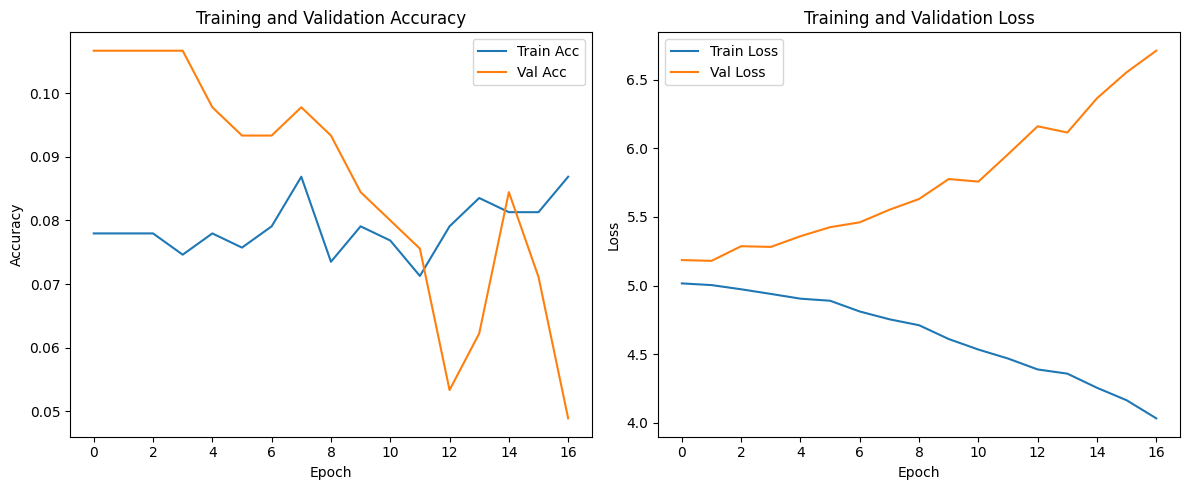

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a Keras 'history' object from model.fit()
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step


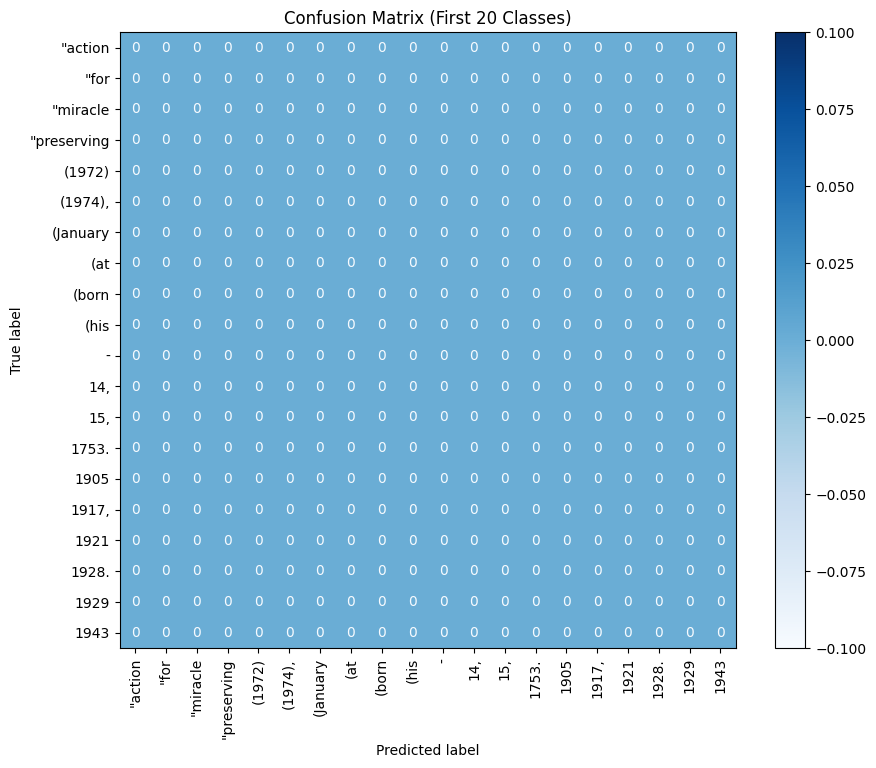

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test set
y_pred = model.predict(X_test).argmax(axis=1)

# Plot confusion matrix (for first 20 classes for readability)
cm = confusion_matrix(y_test, y_pred, labels=range(20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_[:20])
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix (First 20 Classes)')
plt.show()


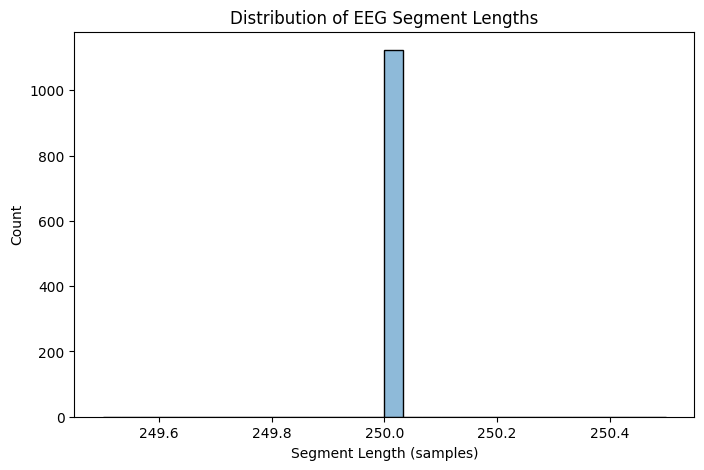

In [ ]:
import seaborn as sns

segment_lengths = [len(seg) for seg in padded_segments]  # Before padding
plt.figure(figsize=(8,5))
sns.histplot(segment_lengths, bins=30, kde=True)
plt.xlabel('Segment Length (samples)')
plt.ylabel('Count')
plt.title('Distribution of EEG Segment Lengths')
plt.show()


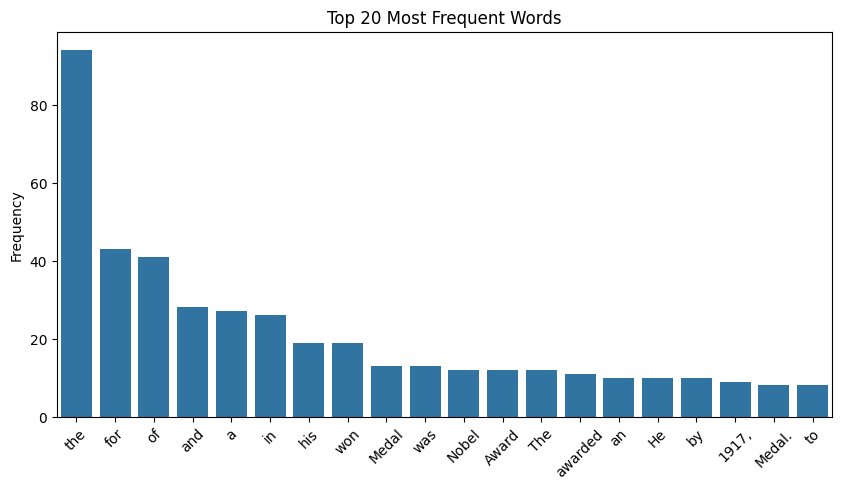

In [ ]:
from collections import Counter

word_counts = Counter(words)
most_common = word_counts.most_common(20)
labels, values = zip(*most_common)
plt.figure(figsize=(10,5))
sns.barplot(x=list(labels), y=list(values))
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words')
plt.show()


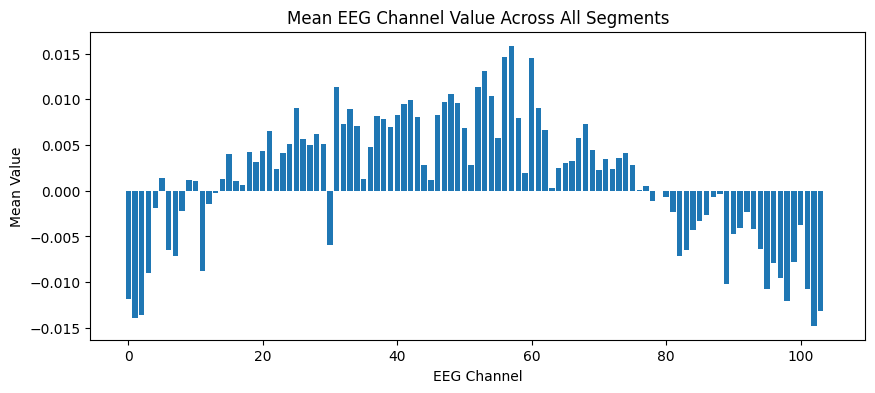

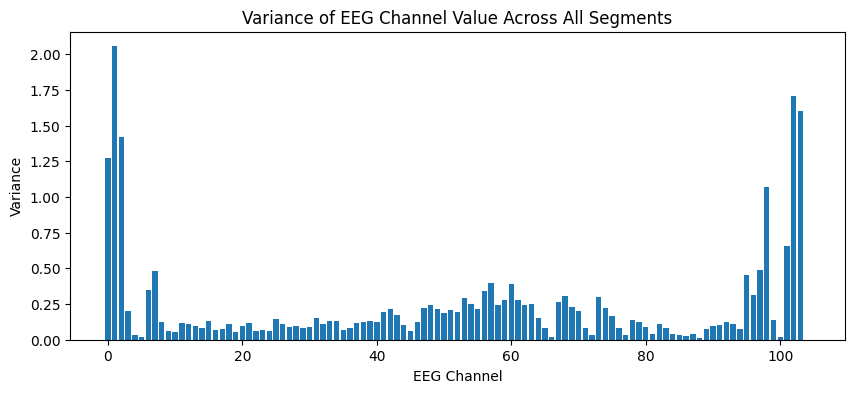

In [ ]:
# For one segment, or the mean across all
mean_eeg = np.mean(X, axis=(0,1))  # Mean across all samples and timepoints
var_eeg = np.var(X, axis=(0,1))

plt.figure(figsize=(10,4))
plt.bar(range(len(mean_eeg)), mean_eeg)
plt.xlabel('EEG Channel')
plt.ylabel('Mean Value')
plt.title('Mean EEG Channel Value Across All Segments')
plt.show()

plt.figure(figsize=(10,4))
plt.bar(range(len(var_eeg)), var_eeg)
plt.xlabel('EEG Channel')
plt.ylabel('Variance')
plt.title('Variance of EEG Channel Value Across All Segments')
plt.show()
